# Previous, unorganized logs

In [1]:
!pwd
!ls ../system/tests/results/

/media/pierre/sharedrive/home/pierre/TUM/Master's Thesis/bio-inspired-navigation/scripts
local_controller_angle	random_positions.out  result.log
long_range_nav.log	re_config.tex	      topological_navigation.py.log


In [2]:
with open('../system/tests/results/topological_navigation.py.log', 'r') as file:
    lines = file.readlines()
lines = [ line.strip() for line in lines ]
lines.pop(0)
lines

['path_index 0 45',
 'path_index 1 21',
 'path_index 2 19',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector navigation success: False',
 'Vector naviga

In [3]:
lines_split = []
current_split = []
for line in lines:
    if line == f'Navigation {len(lines_split)} finished':
        lines_split.append(current_split)
        current_split = []
    else:
        current_split.append(line)
lines_split

[['path_index 0 45',
  'path_index 1 21',
  'path_index 2 19',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation success: False',
  'Vector navigation succ

In [4]:
parse_truth = {'True': True, 'False': False}
def parse(split: list[str]):
    state = 0
    path, successes, limit_reached = [], [], False
    for line in split:
        if line.startswith('path_index'):
            assert state == 0
            _, i, j = line.split(' ')
            assert int(i) == len(path)
            path.append(int(j))
        elif line.startswith('Vector navigation success: '):
            assert state <= 1; state = 1
            truth = line.removeprefix('Vector navigation success: ')
            successes.append(parse_truth[truth])
        else:
            assert state == 1 and line == 'LIMIT WAS REACHED STOPPING HERE'
            limit_reached = True
            state = 2
    return {'path': path, 'successes': successes, 'limit_reached': limit_reached}
topo_navs = list(map(parse, lines_split))

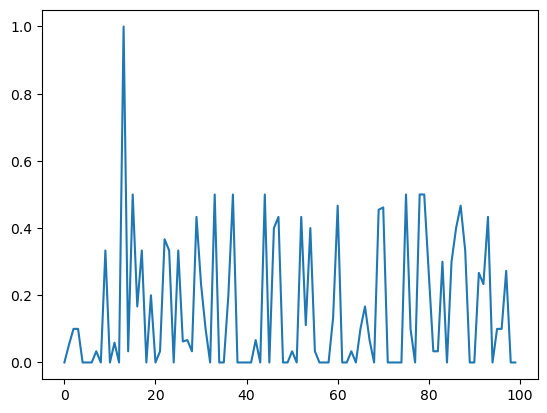

In [7]:
import matplotlib.pyplot as plt
plt.plot([sum(nav['successes']) / len(nav['successes']) for nav in topo_navs])
plt.savefig('/tmp/successes.png')

# New, organized logs

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
with open('topological_nav.log.d/topological_nav.log') as f:
    all_lines = f.readlines()

In [5]:
truth_parser = {'True': True, 'False': False}

lines = filter(lambda line: line.startswith('Vector navigation:'), all_lines)
def parse_line(line):
    line = line.strip()
    assert line.startswith('Vector navigation: '); line = line.removeprefix('Vector navigation: ')
    data = line.split(', ')
    dico = {}
    for dat in data:
        key, value = dat.split('=')
        dico[key] = value
    return truth_parser[dico['success']]
successes = map(parse_line, lines)

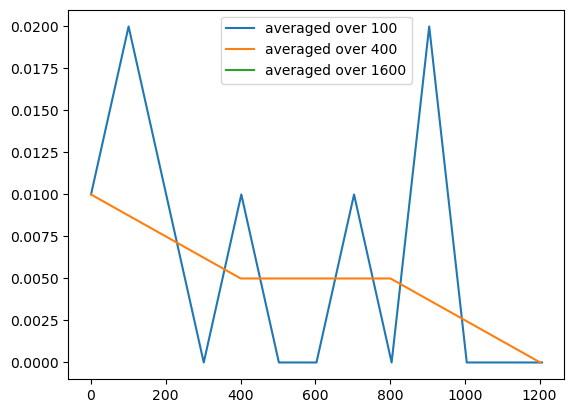

In [6]:
from itertools import tee
try:
    from itertools import batched
except ImportError:
    from system.polyfill import batched

import matplotlib.pyplot as plt

def plot_evolution(it, n):
    batches = batched(it, n=n)
    batch_averages = [sum(batch) / len(batch) for batch in batches]
    plt.plot([ i*(n+0.5) for i in range(len(batch_averages)) ], batch_averages, label=f'averaged over {n}')

precisions = (100, 400, 1600)
for n, successes in zip(precisions, tee(successes, len(precisions))):
    plot_evolution(successes, n=n)
plt.legend()

## Reconstructing the map from the logs

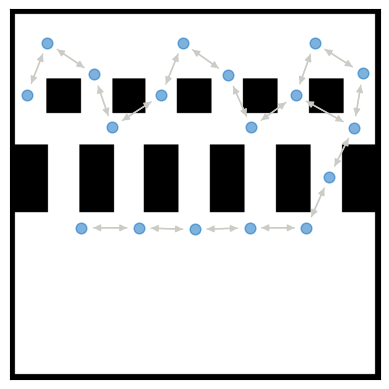

In [7]:
from system.bio_model.cognitive_map import LifelongCognitiveMap
from system.plotting.plotResults import plotTrajectoryInEnvironment
env_model = 'linear_sunburst'
cogmap = LifelongCognitiveMap(load_data_from='linear_sunburst.after_exploration.gpickle', reachability_estimator=None, debug=False)
plotTrajectoryInEnvironment(env_model=env_model, cognitive_map=cogmap, trajectory=False)

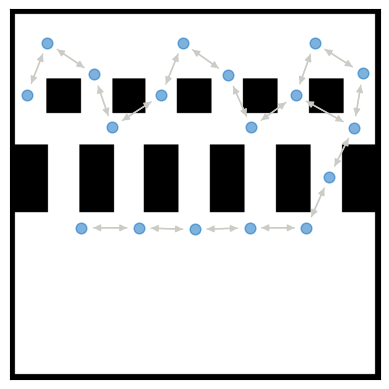

unobstructed_lines : 0.7777777777777778
mean_distance_between_nodes : 1.6711747924596845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:06<00:00, 12.36it/s]


scalar_coverage : 0.9634146341463414


30it [00:01, 17.46it/s]


agreement : 0.5


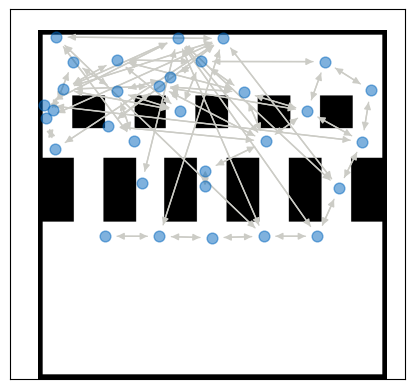

unobstructed_lines : 0.5357142857142857
mean_distance_between_nodes : 1.9961127240601073


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:11<00:00,  6.88it/s]


scalar_coverage : 0.975609756097561


0it [00:01, ?it/s]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [14]:
from system.controller.reachability_estimator.types import PlaceInfo
from system.bio_model.place_cell_model import PlaceCell
import numpy as np

cogmap = LifelongCognitiveMap(load_data_from='linear_sunburst.after_exploration.gpickle', reachability_estimator=None, debug=False)
pcs = cogmap.get_place_cell_network().place_cells

def process(line):
    assert line[-1] == '\n'; line = line[:-1]
    if any(line.startswith(it) for it in ('Using seed', 'Path', 'Last PC', 'adding edge', 'edge [', 'Vector navigation', 'Recomputed path:', 'Navigation ', 'LIMIT WAS REACHED STOPPING HERE')):
        pass
    elif line.startswith('Adding bidirectional edge: '):
        line = line.removeprefix('Adding bidirectional edge: ')
        kvpairs = [ kv.split('=') for kv in line.split(', ')]
        kvpairs = { key: value for key, value in kvpairs }
        cogmap.add_bidirectional_edge_to_map(pcs[int(kvpairs['p'])], pcs[int(kvpairs['q'])], w=float(kvpairs['weight']))
    elif line.startswith('deleting edge ['):
        line = line.removeprefix('deleting edge [')
        line = line.split(']')[0]
        p, q = line.split('-')
        p, q = int(p), int(q)
        cogmap.remove_bidirectional_edge(pcs[p], pcs[q])
    elif line.startswith('Adding node: '):
        line = line.removeprefix('Adding node: ')
        kvpairs = [kv.split('=') for kv in line.split(', ')]
        kvpairs = {key: value for key, value in kvpairs}
        assert int(kvpairs['#']) == len(cogmap.node_network.nodes), (int(kvpairs['#']), len(cogmap.node_network.nodes))
        pos = kvpairs['position']
        assert pos[0] == '[' and pos[-1] == ']'; pos = pos[1:-1]
        pos = tuple(map(float, filter(lambda i:i, pos.split(' '))))
        pc = PlaceCell.from_data(PlaceInfo(pos=pos, angle=None, img=np.array(1), lidar=None, spikings=None))
        pcs.append(pc)
        cogmap.add_node_to_map(pc)
    elif line.startswith('> /') or line.startswith('Uncaught exception'):
        return 2
    elif line.startswith('(Pdb)') or line.startswith('Post mortem debugger'):
        pass
    else:
        try:
            int(line.split(' ')[0]) # PDB l
        except ValueError as err:
            raise ValueError('Unrecognized line:', line) from err
    return 1

from system.tests.map import unobstructed_lines, mean_distance_between_nodes, scalar_coverage, agreement

blocked = 0
for i, line in enumerate(all_lines):
    if i % 1000 == 0:
        plotTrajectoryInEnvironment(env_model=env_model, cognitive_map=cogmap, trajectory=False)
        for fun in (unobstructed_lines, mean_distance_between_nodes, scalar_coverage, agreement):
            print(fun.__name__, ':', fun(cogmap, env_model))
    if blocked:
        blocked -= 1
        continue
    try:
        blocked = process(line) - 1
    except Exception:
        print(line)
        raise

In [12]:
help(cogmap.add_node_to_map)

Help on method add_node_to_map in module system.bio_model.cognitive_map:

add_node_to_map(p: system.bio_model.place_cell_model.PlaceCell) method of system.bio_model.cognitive_map.LifelongCognitiveMap instance
    Adds a new node to the cognitive map



In [31]:
pcs = list(cogmap.node_network.nodes)
p, q = pcs[10], pcs[13]
cogmap.node_network[q][p]

{'weight': 0.5096984422126452}

In [33]:
list(filter(lambda i: i, ' 4.4165791  10.74813662'.strip().split(' ')))

['4.4165791', '10.74813662']